# Lucas Tree
Lucas (1978) considers an economy populated by infinitely many identical individual consumers, in which the only assets are some identical infinitely-lived trees.

## Question 1

In [6]:
!pip install pandas_datareader

In [1]:
#Standard Python Imports
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sts
import pandas_datareader.data as web

In [2]:
start = datetime.datetime(1972, 1, 1)
end = datetime.datetime(2010, 12, 31)

consumption = web.DataReader('PCECC96', 'fred', start, end) 
market = web.DataReader('WILL5000INDFC', 'fred', start, end) 
t_bill = web.DataReader('TB3MS', 'fred', start, end)         
deflator = web.DataReader('GDPDEF', 'fred', start, end)      


df = pd.concat([consumption, market, deflator, t_bill], sort=True)
df = df.groupby(pd.PeriodIndex(df.index, freq='Q'), axis=0).mean() # convert to quarterly

df.columns = ['consumption', 'market', 'deflator', 't_bill']
df['rMarket'] = df.market / (df.deflator*100)
df['rTbill'] = df.t_bill / (df.deflator*100)

df.head() # head() method is used to return top n (5 by default) rows of a data frame or series.

,consumption,market,deflator,t_bill,rMarket,rTbill
DATE,,,,,,
1972Q1,23.458,3307.767,3.436667,1.240000,9.624928,0.003608
1972Q2,23.604,3370.736,3.770000,1.280000,8.940944,0.003395
1972Q3,23.830,3422.682,4.220000,1.293333,8.110621,0.003065
1972Q4,24.134,3503.001,4.863333,1.356667,7.202881,0.002790
1973Q1,24.412,3566.957,5.700000,1.306667,6.257819,0.002292


Assume that 𝛽 = 0.99 (since this is quarterly data, this implies an annual risk- free rate of about 4%). Calculate empirical analogs of the expected values and covariance in (5). Using scipy.optimize.broyden1, solve for the value of 𝛾 that leads to equation (5) holding.


In [3]:
class GMM_Lucas( object ):   
    def __init__(self, data=df, options='q3'):
        
        self.data = data
        self.options = options
                
        R = self.data.rMarket / self.data.rMarket.shift(1)
        self.R = R.dropna()
        
    def estimate_m(self, gamma, beta):
        ratio = self.data.consumption / self.data.consumption.shift(1)
        
        MUC = ratio ** -gamma     
        m = beta * MUC
        return m[1:]
 
    def objective(self, params):
        if params.size == 1:
            gamma = params
            beta = 0.99
            
        if self.options == 'q1':
            m = self.estimate_m(gamma, beta)
            cov = np.cov(m, self.R)[0,1]              # var/cov matrix, take COV
            error = cov + m.mean() * self.R.mean() - 1
            return error
        
        elif self.options == 'q3':        
            m = self.estimate_m(gamma, beta)
            exp = self.R * m
            error = exp.mean() - 1
            return error
        
        elif self.options == 'q4':
            beta, gamma = params
            m = self.estimate_m(gamma, beta)
            cov = np.cov(m, self.R)[0,1]
            err1 = cov + m.mean() * self.R.mean() - 1

            exp = self.R * m
            err2 = exp.mean() - 1
            
            e = np.array([err1, err2])
            return e.T @ np.eye(2) @ e

                   
    def estimate_gamma(self):
        if self.options == 'q4':
            xguess = np.ones(2)
            result = opt.minimize(self.objective, xguess)
        else:
            xguess = np.ones(1)
            ### Non=linear solver gets very different answer to Natasha, come back
            result = opt.broyden1(self.objective, xguess)
        return result
    
    def plot(self):
        n = 60
        N = 5
        γ_grid = np.linspace(0, 5, n)
        β_grid = np.linspace(0.95, 0.99, N)

        cons = self.data.rMarket
        tbill = self.data.rTbill

        gmm_values = np.empty((n, N))
        for i in range(n):
            for j in range(N):
                param = np.array( [ γ_grid[i], β_grid[j] ])
                gmm_values[i, j] = self.objective(param)
                
        plt.figure(figsize=(10, 8))
        for j in range(N):
            plt.plot(γ_grid, gmm_values[:, j], label=f'{β_grid[j]:.2f}')
        plt.title('Value of GMM objective function')
        plt.xlabel('$\gamma$')
        plt.legend()
        plt.show()

In [4]:
Question1 = GMM_Lucas(data=df, options='q1')
print("Gamma = ",Question1.estimate_gamma())

Gamma =  [5.45166773]


## Question 2

Gamma $\gamma$ could be elicited from different data sets and then one can reach at a conclusion of what a reasonable value of this parameter could be. [Cochrane] (https://faculty.chicagobooth.edu/john.cochrane/research/papers/samplechapters.pdf)  uses a $\gamma=241$ to illustrate his results.

## Question 3

In [15]:
Question3 = GMM_Lucas(data=df, options='q3')
print("Gamma = ",Question3.estimate_gamma())

Gamma =  [5.45020617]


## Question 4

Beta  =  0.9525623703046379 
Gamma =  1.000414934436633


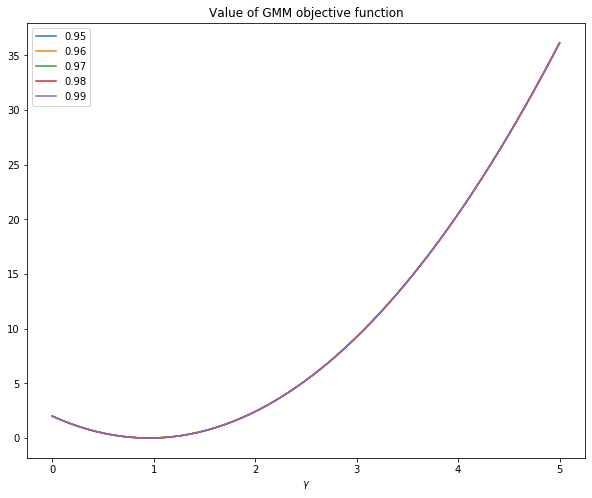

In [16]:
Question4 = GMM_Lucas(data=df, options='q4')
ans = Question4.estimate_gamma().x
print("Beta  = ", ans[0], "\nGamma = ", ans[1])
Question4.plot()